# Pass Solars - FA Cup Example

In this week's visual we'll explore pass "solars" using WhoScored data from the FA Cup fixture between Man City and Arsenal.

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
from matplotlib.patches import RegularPolygon
import matplotlib.patches as mpatches
from matplotlib import cm
import numpy as np
from matplotlib import cm
from highlight_text import fig_text, ax_text
from ast import literal_eval
from adjustText import adjust_text

# First time we use seaborn
import seaborn as sns

from mplsoccer import Pitch, VerticalPitch, lines

from PIL import Image
import urllib
import os

from math import acos, pi
from scipy.stats import circmean

In [3]:
font_path = "../assets/fonts"
for x in os.listdir(font_path):
    for y in os.listdir(f"{font_path}/{x}"):
        if y.split(".")[-1] == "ttf":
            fm.fontManager.addfont(f"{font_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
            except Exception:
                continue

plt.style.use("../assets/stylesheets/soc_base.mplstyle")

## Data

In [6]:
data = pd.read_csv('data/02012023_fa_cup_solar.csv', index_col=0, low_memory=False)
data['qualifiers'] = [literal_eval(x) for x in data['qualifiers']]
data['satisfied_events_types'] = [literal_eval(x) for x in data['satisfied_events_types']]

## Compute angles & Circular Mean

In [55]:
df = data[data['outcome_type'] == 'Successful'].reset_index(drop=True)

In [57]:
df.loc[:, 'is_open_play'] = True
for index, record in enumerate(df['qualifiers']):
    for attr in record:
        key_search = list(attr.keys())[0]
        if key_search in ['GoalKick', 'FreekickTaken', 'CornerTaken', 'ThrowIn']:
            df.at[index, 'is_open_play'] = False

In [59]:
df = df[df['is_open_play']].reset_index(drop=True)

In [60]:
df = df.assign(dx = lambda x: x.end_x - x.x)
df = df.assign(dy = lambda x: x.end_y - x.y)
df = df.assign(length_pass = lambda x: (x.dx**2 + x.dy**2)**(1/2))

In [61]:
df['angle'] = [
    acos( dx / length_pass) for dx, length_pass in zip(df['dx'], df['length_pass'])
]
df['angle'] = [
    pi + angle if dy < 0 else angle for angle, dy in zip(df['angle'], df['dy'])
]

In [62]:
arsenal_passes = df[df['team_name'] == 'Arsenal'].reset_index(drop=True)
mcity_passes = df[df['team_name'] != 'Arsenal'].reset_index(drop=True)

In [247]:
# -- Manchester City
mc_angle = mcity_passes.groupby(['pass_recipient']).apply(lambda x: circmean(x.angle)).reset_index(name='angle')
mc_length = mcity_passes.groupby(['pass_recipient'])['length_pass'].mean().reset_index()
mc_size = mcity_passes.groupby(['pass_recipient'])['match_id'].size().reset_index(name='num_passes')

mc_summary = pd.merge(mc_angle, mc_length, on='pass_recipient')
mc_summary = pd.merge(mc_summary, mc_size, on='pass_recipient')

# -- Arsenal
ar_angle = arsenal_passes.groupby(['pass_recipient']).apply(lambda x: circmean(x.angle)).reset_index(name='angle')
ar_length = arsenal_passes.groupby(['pass_recipient'])['length_pass'].mean().reset_index()
ar_size = arsenal_passes.groupby(['pass_recipient'])['match_id'].size().reset_index(name='num_passes')

ar_summary = pd.merge(ar_angle, ar_length, on='pass_recipient')
ar_summary = pd.merge(ar_summary, ar_size, on='pass_recipient')

## Pass Solar Style

In this section we detail our polar plot with some nice ticks and formatting (most of the source code comes from [here](https://github.com/rougier/scientific-visualization-book/blob/master/code/scales-projections/projection-polar-histogram.py)).

In [290]:
def plot_fancy_polar(ax):
    '''
    This function plots a fancy polar chart with ticks and
    other cool aesthetics.
    '''
    # -- Remove ticks and labels.
    ax.set_thetalim(0, 2 * np.pi)
    ax.set_rlim(0, 35)
    ax.set_xticks([])
    ax.set_xticklabels([])
    # -- Aux computation for bands
    ax.set_yticks(np.linspace(0, 40, 9))
    ax.set_yticklabels([])
    ax.tick_params("both", grid_alpha=0.50, grid_zorder=-10, grid_linewidth=0.5)
    ax.set_ylabel(None)

    # -- Draw angle ticks
    radius = ax.get_rmax()
    length = 0.05 * radius
    for i in range(360):
        angle = np.pi * i / 180
        ax.plot(
            [angle, angle],
            [radius, radius - length],
            linewidth=0.50,
            color="0.75",
            clip_on=False,
        )
    for i in range(0, 360, 5):
        angle = np.pi * i / 180
        ax.plot(
            [angle, angle],
            [radius, radius - 2 * length],
            linewidth=0.75,
            color="0.75",
            clip_on=False,
        )
    # Draw edges and add annotations
    for i in range(0, 360, 90):
        angle = np.pi * i / 180
        ax.plot([angle, angle], [radius, 0], zorder=3, linewidth=1.00, color="gray")
        if i == 0:
            text_ = 'Opposition goal'
        elif i == 90:
            text_ = 'Left'
        elif i == 180:
            text_ = 'Own goal'
        else:
            text_ = 'Right'
        ax.text(
            angle,
            radius + 4 * length,
            text_,
            zorder=3,
            rotation=i - 90,
            rotation_mode="anchor",
            va="top",
            ha="center",
            size="x-small",
            family="Georgia",
            color="black",
        )

    # --  Radius ticks
    length = .5*length
    def polar_to_cartesian(theta, radius):
        x = radius * np.cos(theta)
        y = radius * np.sin(theta)
        return np.array([x, y])


    def cartesian_to_polar(x, y):
        radius = np.sqrt(x ** 2 + y ** 2)
        theta = np.arctan2(y, x)
        return np.array([theta, radius])


    for i in range(0, 40, 5):
        P0 = 0, i
        P1 = cartesian_to_polar(*(polar_to_cartesian(*P0) + [0, 0.75 * length]))
        ax.plot([P0[0], P1[0]], [P0[1], P1[1]], linewidth=0.50, color="gray")

    for i in range(0, 40, 5):
        P0 = 0, i
        P1 = cartesian_to_polar(*(polar_to_cartesian(*P0) + [0, +1.0 * length]))
        ax.plot([P0[0], P1[0]], [P0[1], P1[1]], zorder=3, linewidth=0.75, color="gray")
        P1 = cartesian_to_polar(*(polar_to_cartesian(*P0) + [0, -1.0 * length]))
        text = ax.text(
            P1[0],
            P1[1],
            f'{i*1.15:.0f}',
            zorder=3,
            va="top",
            ha="center",
            size="xx-small",
            family="Georgia",
            color="gray",
        )
        text.set_path_effects(
            [path_effects.Stroke(linewidth=2, foreground="white"), path_effects.Normal()]
        )


    # -- Circular bands
    n = 35
    T = np.linspace(0, 2 * np.pi, n)
    color_even = "0.95"
    increase_size = 35/7
    cutoff = 0
    while cutoff <= 35:
        if cutoff % 2 == 0:
            color = color_even
            ax.fill_between(T, cutoff, cutoff + increase_size, color=color_even, zorder=-50)
        cutoff += increase_size
    ax.scatter([0], [0], 20, facecolor="white", edgecolor="gray", zorder=1000)


In [267]:
mc_summary['annotate'] = [True if x > mc_summary['num_passes'].quantile(.35) else False for x in mc_summary['num_passes']]
ar_summary['annotate'] = [True if x > ar_summary['num_passes'].quantile(.35) else False for x in ar_summary['num_passes']]

## Final Viz

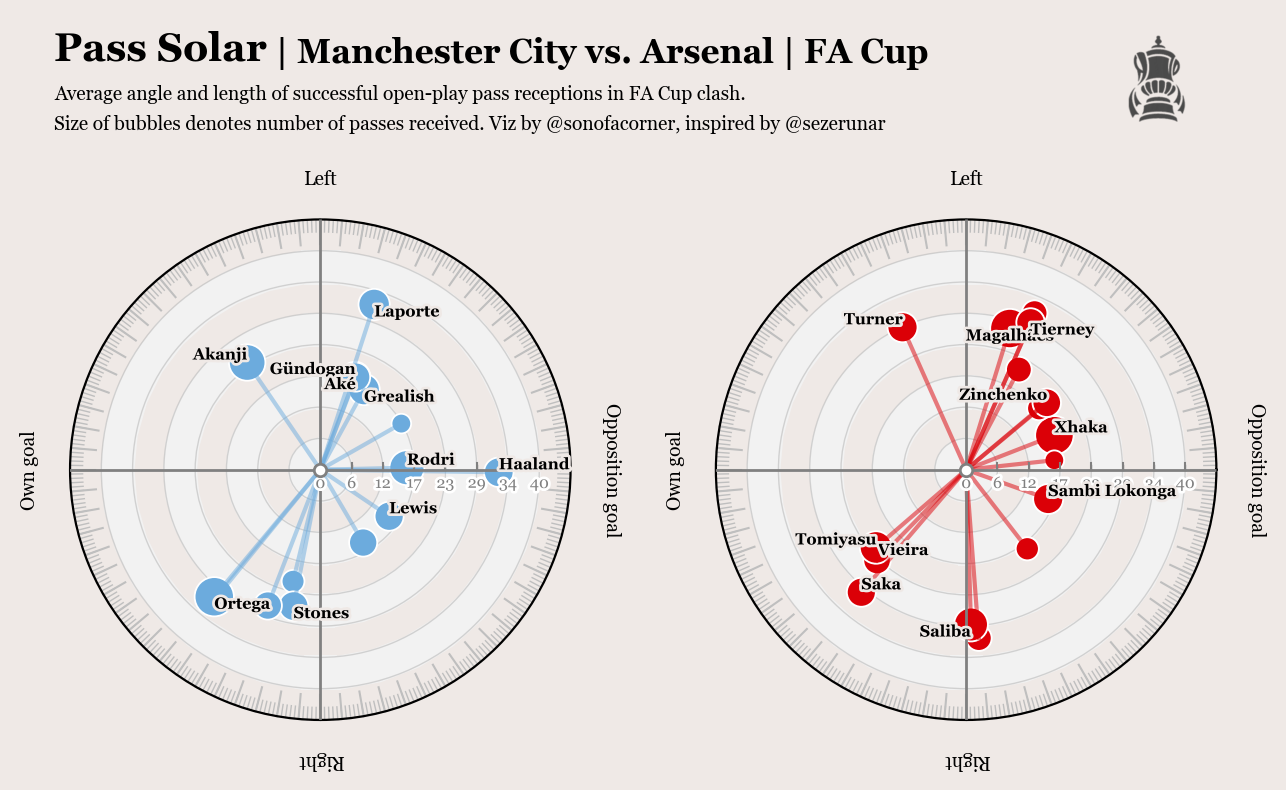

In [307]:
fig = plt.figure(dpi=200)
ax_mc = plt.subplot(1, 2, 1, projection="polar", frameon=True)
ax_ars = plt.subplot(1, 2, 2, projection="polar", frameon=True)

# -- Manchester City
plot_fancy_polar(ax_mc)
sns.scatterplot(
    data=mc_summary, x='angle', y='length_pass', color='#6CABDD',
    size='num_passes', sizes=(50,200), legend=False, ax=ax_mc, zorder=2)
ax_mc.set_ylabel(None)
texts = []
annotate_mc = mc_summary[mc_summary['annotate']]
for index in range(annotate_mc.shape[0]):
    player_name = annotate_mc['pass_recipient'].iloc[index]
    if len(player_name.split(' ')) > 1:
        player_text = ' '.join(player_name.split(' ')[1:])
    else:
        player_text = player_name
    texts += [
        ax_mc.text(
            x=annotate_mc['angle'].iloc[index], y=annotate_mc['length_pass'].iloc[index],
            s=f"{player_text}",
            path_effects=[path_effects.Stroke(linewidth=2, foreground=fig.get_facecolor()), 
            path_effects.Normal()], color='black',
            family='Georgia', weight='bold', size='xx-small', zorder=10
        )
    ]

for index, length in enumerate(mc_summary['length_pass']):
    ax_mc.plot(
        [0, mc_summary['angle'].iloc[index]],
        [0, length],
        zorder=2, alpha=.5, color='#6CABDD'
    )
adjust_text(texts, precision=5.25, expand_text=(.5, 4), ax=ax_mc)
# -- Arsenal
plot_fancy_polar(ax_ars)
sns.scatterplot(
    data=ar_summary, x='angle', y='length_pass', color='#DB0007',
    size='num_passes', sizes=(50,200), legend=False, ax=ax_ars, zorder=2)
ax_ars.set_ylabel(None)
texts = []
annotate_ar = ar_summary[ar_summary['annotate']]
for index in range(annotate_ar.shape[0]):
    player_name = annotate_ar['pass_recipient'].iloc[index]
    if len(player_name.split(' ')) > 1:
        player_text = ' '.join(player_name.split(' ')[1:])
    else:
        player_text = player_name
    texts += [
        ax_ars.text(
            x=annotate_ar['angle'].iloc[index], y=annotate_ar['length_pass'].iloc[index],
            s=f"{player_text}",
            path_effects=[path_effects.Stroke(linewidth=2, foreground=fig.get_facecolor()), 
            path_effects.Normal()], color='black',
            family='Georgia', weight='bold', size='xx-small', zorder=10
        )
    ]

for index, length in enumerate(ar_summary['length_pass']):
    ax_ars.plot(
        [0, ar_summary['angle'].iloc[index]],
        [0, length],
        zorder=2, alpha=.5, color='#DB0007'
    )
adjust_text(texts, precision=5.25, expand_text=(.5, 4), ax=ax_ars)

plt.subplots_adjust(wspace=.25, hspace=-.5)

fig_text(
    x=0.12, y=1.14, s='<Pass Solar> | Manchester City vs. Arsenal | FA Cup', family='Georgia',
    ha='left', va='center', weight='bold', size='large',
    highlight_textprops = [{'weight':'bold', 'size':'x-large'}] 
)
fig_text(
    x=0.12, y=1.05, s='Average angle and length of successful open-play pass receptions in FA Cup clash.\nSize of bubbles denotes number of passes received. Viz by @sonofacorner, inspired by @sezerunar', 
    family='Georgia',
    ha='left', va='center', size='x-small',
)

image_ax = fig.add_axes(
    [.78, 1.02, .15, .15],
    fc='None'
)
fotmob_url = 'https://images.fotmob.com/image_resources/logo/leaguelogo/132.png'
club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}')).convert('LA')
image_ax.imshow(club_icon)
image_ax.axis('off')

plt.savefig(
	"figures/02012023_pass_solar.png",
	dpi = 500,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

plt.savefig(
	"figures/02012023_pass_solar_tr.png",
	dpi = 500,
	facecolor = "none",
	bbox_inches="tight",
    edgecolor="none",
	transparent = True
)